In [1]:
import pandas as pd
from openpyxl import load_workbook
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from pydantic import BaseModel, ConfigDict
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# **load data**

In [2]:
weather_dataset = '../main_datasets/exogens_params/weather_dataset_v2.csv'

In [3]:
data = pd.read_csv(weather_dataset, index_col='timeline', date_format='timeline')

In [4]:
data

,описание погоды,время,температура,скорость ветра,давление
timeline,,,,,
2022-01-01 00:00:00,"пасмурно, снег",00:00,-3.0,0.0,738.0
2022-01-01 01:00:00,"пасмурно, снег",00:00,-3.0,0.0,738.0
2022-01-01 02:00:00,"пасмурно, снег",00:00,-3.0,0.0,738.0
2022-01-01 03:00:00,"пасмурно, снег",03:00,-2.0,1.0,737.0
2022-01-01 04:00:00,"пасмурно, снег",03:00,-2.0,1.0,737.0
...,...,...,...,...,...
2024-12-31 19:00:00,"пасмурно, без осадков",18:00,1.0,0.0,750.0
2024-12-31 20:00:00,"пасмурно, без осадков",18:00,1.0,0.0,750.0
2024-12-31 21:00:00,"пасмурно, без осадков",21:00,1.0,1.0,749.0


# **Preprocess data**

In [6]:
weathers = np.unique(sum(data[['описание погоды']].map(lambda a: a.split(', ')).to_numpy().tolist(), []))

In [7]:
encode_weather_type = pd.DataFrame([{k: int(k in i) for k in weathers} for i in data['описание погоды'].map(lambda a: a.split(', '))], index=data.index)

In [8]:
encode_weather_type

,без осадков,дождь,малооблачно,облачно,осадки,пасмурно,сильный снег,слабые осадки,слабый дождь,слабый снег,снег,ясно
timeline,,,,,,,,,,,,
2022-01-01 00:00:00,0,0,0,0,0,1,0,0,0,0,1,0
2022-01-01 01:00:00,0,0,0,0,0,1,0,0,0,0,1,0
2022-01-01 02:00:00,0,0,0,0,0,1,0,0,0,0,1,0
2022-01-01 03:00:00,0,0,0,0,0,1,0,0,0,0,1,0
2022-01-01 04:00:00,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,1,0,0,0,0,1,0,0,0,0,0,0
2024-12-31 20:00:00,1,0,0,0,0,1,0,0,0,0,0,0
2024-12-31 21:00:00,1,0,0,0,0,1,0,0,0,0,0,0


In [9]:
weathers

array(['без осадков', 'дождь', 'малооблачно', 'облачно', 'осадки',
       'пасмурно', 'сильный снег', 'слабые осадки', 'слабый дождь',
       'слабый снег', 'снег', 'ясно'], dtype='<U13')

In [7]:
data_weather_encoded = pd.concat([data, encode_weather_type], axis=1).drop(['описание погоды', 'время'], axis=1)

In [8]:
weather_preasure_scaler = StandardScaler().fit(data_weather_encoded[['давление']])

In [9]:
data_weather_encoded[['давление']] = weather_preasure_scaler.transform(data_weather_encoded[['давление']])

In [10]:
data_weather_encoded.columns = data_weather_encoded.columns.map(str)

In [11]:
data_weather_encoded.describe()

,температура,скорость ветра,давление,без осадков,дождь,малооблачно,облачно,осадки,пасмурно,сильный снег,слабые осадки,слабый дождь,слабый снег,снег,ясно
count,15288.00000,15288.000000,1.528800e+04,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000,15288.000000
mean,0.18073,1.242347,-5.688804e-15,0.793367,0.004121,0.072998,0.028257,0.001766,0.751374,0.002943,0.021978,0.050628,0.097527,0.027669,0.147370
std,6.08900,1.315757,1.000033e+00,0.404903,0.064064,0.260142,0.165713,0.041989,0.432231,0.054176,0.146616,0.219244,0.296684,0.164027,0.354486
min,-18.00000,0.000000,-3.293516e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.00000,1.000000,-7.050942e-01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,1.000000,4.986199e-02,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.00000,2.000000,5.891164e-01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.00000,41.000000,2.638283e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Clusterization**

In [12]:
def timeline_processor_primitive(tl: pd.DataFrame) -> np.ndarray:
    return tl.to_numpy().reshape(-1)

def timeline_processor_delta(tl: pd.DataFrame) -> np.ndarray:
    return abs(tl.iloc[0] - tl.iloc[1]).loc[['температура',	'скорость ветра', 'давление']]

## Типы погоды по дельте

Рассмотрим типы погоды по разнице между текущей и предыдущей

100%|██████████| 18/18 [00:12<00:00,  1.43it/s]


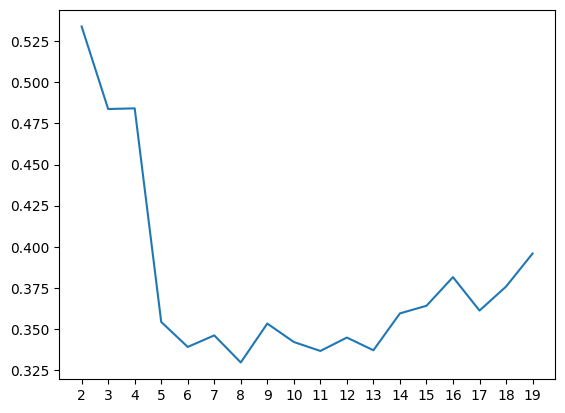

In [13]:
ss = []
w = 12
ddt = data_weather_encoded.iloc[::3]
x = [timeline_processor_delta(ddt[i:i+w:w-1]) for i in range(ddt.shape[0]-w)]
s, e, d = 2, 20, 1
for i in tqdm(range(s, e, d)):
    ss.append(silhouette_score(x, KMeans(i, n_init='auto').fit(x).labels_))
plt.plot(ss);
plt.xticks(range((e-s)//d), range(s, e, d));

## Три клсастера

In [203]:
uc = ['count', 'mean', 'std']
n = 4
c = KMeans(n, n_init='auto').fit(x).labels_
pd.concat([pd.DataFrame(x)[c==c_i].describe().loc[uc].set_index(pd.DataFrame(x)[c==0].describe().loc[uc].index + f'_{c_i}') for c_i in range(n)])

,температура,скорость ветра,давление
count_0,498.000000,498.000000,498.000000
mean_0,5.172691,0.975904,0.689479
std_0,1.047320,0.816962,0.591493
count_1,983.000000,983.000000,983.000000
mean_1,1.574771,0.909461,0.618058
std_1,0.985772,0.824116,0.550010
count_2,201.000000,201.000000,201.000000
mean_2,10.029851,1.124378,0.858195
std_2,2.240336,0.848206,0.810887
count_3,2.000000,2.000000,2.000000


## 8 кластеров

In [207]:
uc = ['mean']
n = 11
c = KMeans(n, n_init='auto').fit(x).labels_
pd.concat([pd.DataFrame(x)[c==c_i].describe().loc[uc].set_index(pd.DataFrame(x)[c==0].describe().loc[uc].index + f'_{c_i}') for c_i in range(n)])

,температура,скорость ветра,давление
mean_0,0.526104,0.771084,0.585609
mean_1,7.421488,1.082645,0.737998
mean_2,3.000000,0.650888,0.567696
mean_3,2.000000,40.000000,0.653398
mean_4,13.775000,1.375000,1.233289
mean_5,9.609091,0.963636,0.740518
mean_6,5.432950,1.003831,0.724746
mean_7,2.121739,1.382609,0.718264
mean_8,0.777778,2.341880,0.568698
mean_9,1.518349,0.000000,0.614934


# - 

100%|██████████| 18/18 [00:39<00:00,  2.22s/it]


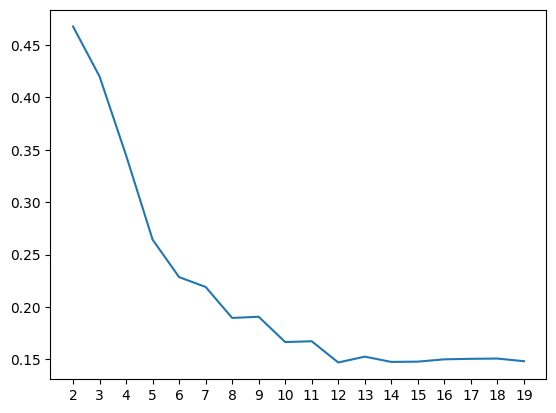

In [132]:
ss = []
x = [timeline_processor_primitive(data_weather_encoded[i:i+12]) for i in range(data_weather_encoded.shape[0]-12)]
s, e, d = 2, 20, 1
for i in tqdm(range(s, e, d)):
    ss.append(silhouette_score(x, AgglomerativeClustering(n_clusters=i).fit_predict(x)))
plt.plot(ss);
plt.xticks(range((e-s)//d), range(s, e, d));